<a href="https://colab.research.google.com/github/ksetdekov/trip_choice_optimizer/blob/master/test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd

from  scipy.stats import gamma, norm
from mvsampling.mvsampling import HandsTable
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import PowerTransformer

In [2]:
# np.random.seed(7336) # фиксируем seed

# risk tolerance
$$\rho = 3.37$$

# initialize

In [3]:
mu_hat_i = 0 # mean
t_i = 0
alpha_i = 0.5
beta_i = 0.5
# rho = 3.37
rho = 1

In [4]:
def update_mean(X, T_last, mu_last):
    mu_new = T_last * mu_last / (T_last + 1) + X / (T_last + 1)
    return mu_new

def update_samples(T):
    return T + 1

def update_shape(a):
    return a + 0.5

def update_rate(X, mu_last, beta_last, T_last):
    beta_new = beta_last + (T_last / (T_last + 1)) * (np.square(X - mu_last)) / 2
    return beta_new

In [5]:
hands = pd.DataFrame({'name': ['трамвай + 944', 'с799 + пешком', 'пешком + 944', 'мотоцикл', 'с799 + 944', 
                               'рыжая + жёлтая + салатовая', 'трамвай + салатовая',
                               'каршеринг', 'серая + салатовая', 'рыжая + фиолетовая + салатовая', 'рыжая + салатовая',
                               'машина', 'самокат', '2гис', 'яндекс карты', 'гугл карты', 'citymapper', 'транспорт москвы',
                               'свой велосипед', 'московский велосипед']})

In [6]:
hands['mu'] = 0
hands['Te'] = 0
hands['alpha'] = 0.5
hands['beta'] = 0.5

In [7]:
def to_minutes(timestr: str):
  '''
  convert timestr to float minutes
  '''
  return pd.to_timedelta(timestr).total_seconds()/60

In [8]:
def update_hands(hands, name, value):
    if isinstance(value, str):
        try:
            value = to_minutes(value)
        except ValueError:
            raise ValueError('input time string in hh:mm:ss format')
    elif isinstance(value, float) or isinstance(value, int):
        pass
    else:
        raise ValueError('input time string or int/float value')
    # print(value)
    _, mu, t, alpha, beta = hands[hands.name ==name].values[0]
    beta = update_rate(value, mu, beta, t)
    mu =  update_mean(value, t, mu)
    t = update_samples(t)
    alpha = update_shape(alpha)

    # print(mu, t, alpha, beta)

    hands.loc[hands.name ==name, 'mu'] = mu
    hands.loc[hands.name ==name, 'Te'] = t
    hands.loc[hands.name ==name, 'alpha'] = alpha
    hands.loc[hands.name ==name, 'beta'] = beta

    return hands


In [9]:
hands = update_hands(hands, 'мотоцикл', 20)
hands = update_hands(hands, 'рыжая + жёлтая + салатовая', 47.63)
hands = update_hands(hands, 'каршеринг', 31.75)
hands = update_hands(hands, 'рыжая + салатовая', 52.6)
hands = update_hands(hands, 'каршеринг', 23.15)
hands = update_hands(hands, 'рыжая + фиолетовая + салатовая', 52.82)
hands = update_hands(hands, 'серая + салатовая', 52.37)
hands = update_hands(hands, 'мотоцикл', 21.05)
hands = update_hands(hands, 'мотоцикл', 26.40)
hands = update_hands(hands, 'мотоцикл', "0:25:18")
hands = update_hands(hands, 'мотоцикл', "0:24:54")
hands = update_hands(hands, 'мотоцикл', "0:26:51")
hands = update_hands(hands, 'каршеринг', "0:28:04")
hands = update_hands(hands, 'каршеринг', "0:28:05")
hands = update_hands(hands, 'мотоцикл', "0:24:54")
hands = update_hands(hands, 'мотоцикл', "0:26:58")
hands = update_hands(hands, 'мотоцикл', "0:26:29")
hands = update_hands(hands, 'машина', "0:23:59")
hands = update_hands(hands, 'каршеринг', "0:36:41")
hands = update_hands(hands, 'машина', "0:24:49")
hands = update_hands(hands, 'машина', "0:21:56")
hands = update_hands(hands, 'машина', "0:22:03")
hands = update_hands(hands, 'машина', "0:23:21")
hands = update_hands(hands, 'мотоцикл', "0:27:45")
hands = update_hands(hands, 'машина', "0:22:26")
hands = update_hands(hands, 'машина', "0:25:00")
hands = update_hands(hands, 'машина', "0:24:07")
hands = update_hands(hands, 'машина', "0:23:38")
hands = update_hands(hands, 'машина', "0:24:13")
hands = update_hands(hands, 'машина', "0:25:32")
hands = update_hands(hands, 'машина', "0:22:11")
hands = update_hands(hands, 'самокат', "0:47:17")
hands = update_hands(hands, 'машина', "0:23:33")
hands = update_hands(hands, 'машина', "0:22:54")
hands = update_hands(hands, 'машина', "0:22:42")
hands = update_hands(hands, 'каршеринг', "0:33:02")
hands = update_hands(hands, 'машина', "0:23:31")
hands = update_hands(hands, 'машина', "0:24:39")
hands = update_hands(hands, 'машина', "0:24:16")
hands = update_hands(hands, 'машина', "0:28:12")
hands = update_hands(hands, 'трамвай + 944', "0:41:35")
hands = update_hands(hands, 'машина', "0:26:27")
hands = update_hands(hands, 'машина', "0:23:55")
hands = update_hands(hands, 'с799 + 944', "0:45:48")
hands = update_hands(hands, 'машина', "0:32:23")
hands = update_hands(hands, 'машина', "0:22:34")
hands = update_hands(hands, 'машина', "0:25:00")
hands = update_hands(hands, 'машина', "0:27:01")
hands = update_hands(hands, 'каршеринг', "0:31:14")
hands = update_hands(hands, 'трамвай + салатовая', "0:48:40")
hands = update_hands(hands, 'пешком + 944', "0:46:56")
hands = update_hands(hands, 'машина', "0:31:17")
hands = update_hands(hands, 'каршеринг', "0:34:08")
hands = update_hands(hands, 'машина', "0:31:18")
hands = update_hands(hands, 'машина', "0:27:10")
hands = update_hands(hands, 'каршеринг', "0:25:51")
hands = update_hands(hands, 'транспорт москвы', "0:49:36")
hands = update_hands(hands, 'яндекс карты', "0:44:21")
hands = update_hands(hands, 'с799 + пешком', "0:55:24")
hands = update_hands(hands, 'гугл карты', "0:40:50")
hands = update_hands(hands, '2гис', "0:59:04")
hands = update_hands(hands, 'каршеринг', "0:29:00")
hands = update_hands(hands, 'citymapper', "0:52:31")
hands = update_hands(hands, 'машина', "0:27:36")
hands = update_hands(hands, 'машина', "0:26:23")
hands = update_hands(hands, 'машина', "0:24:04")
hands = update_hands(hands, 'гугл карты', "0:44:06")
hands = update_hands(hands, 'машина', "0:33:59")
hands = update_hands(hands, 'каршеринг', "0:26:42")
hands = update_hands(hands, 'машина', "0:26:36")
hands = update_hands(hands, 'машина', "0:23:13")
hands = update_hands(hands, 'трамвай + 944', "0:48:14")
hands = update_hands(hands, 'машина', "0:25:05")
hands = update_hands(hands, 'машина', "0:30:01")
hands = update_hands(hands, 'каршеринг', "0:30:13")
hands = update_hands(hands, 'машина', "0:23:31")
hands = update_hands(hands, 'с799 + 944', "0:44:02")
hands = update_hands(hands, 'машина', "0:32:43")
hands = update_hands(hands, 'каршеринг', "0:25:07")
hands = update_hands(hands, 'гугл карты', "0:55:16")
hands = update_hands(hands, 'каршеринг', "0:35:15")
hands = update_hands(hands, 'с799 + 944', "0:56:38")
hands = update_hands(hands, 'машина', "0:23:55")
hands = update_hands(hands, 'машина', "0:22:29")
hands = update_hands(hands, 'яндекс карты', "0:47:40")
hands = update_hands(hands, 'каршеринг', "0:25:10")
hands = update_hands(hands, 'машина', "0:27:06")
hands = update_hands(hands, 'каршеринг', "0:30:21")
hands = update_hands(hands, 'машина', "0:23:50")
hands = update_hands(hands, 'машина', "0:21:28")
hands = update_hands(hands, 'машина', "0:26:38")
hands = update_hands(hands, 'машина', "0:21:33")
hands = update_hands(hands, 'машина', "0:25:22")
hands = update_hands(hands, 'каршеринг', "0:29:08")
hands = update_hands(hands, 'каршеринг', "0:22:20")
hands = update_hands(hands, 'машина', "0:22:37")
hands = update_hands(hands, 'машина', "0:23:22")
hands = update_hands(hands, 'машина', "0:23:09")
hands = update_hands(hands, 'каршеринг', "0:26:06")
hands = update_hands(hands, 'машина', "0:26:10")
hands = update_hands(hands, 'машина', "0:29:32")
hands = update_hands(hands, 'каршеринг', "0:27:13")
hands = update_hands(hands, 'каршеринг', "0:26:02")
hands = update_hands(hands, 'машина', "0:31:01")
hands = update_hands(hands, 'машина', "0:23:00")
hands = update_hands(hands, 'каршеринг', "0:38:52")
hands = update_hands(hands, 'машина', "0:23:29")
hands = update_hands(hands, 'машина', "0:22:10")
hands = update_hands(hands, 'машина', "0:24:05")
hands = update_hands(hands, 'машина', "0:23:24")
hands = update_hands(hands, 'каршеринг', "0:31:12")
hands = update_hands(hands, 'рыжая + жёлтая + салатовая', "0:49:05")
hands = update_hands(hands, 'машина', "0:26:40")
hands = update_hands(hands, 'машина', "0:29:12")
hands = update_hands(hands, 'машина', "0:25:00")
hands = update_hands(hands, 'пешком + 944', "0:52:59")
hands = update_hands(hands, 'машина', "0:22:21")
hands = update_hands(hands, 'машина', "0:23:28")
hands = update_hands(hands, 'машина', "0:23:59")
hands = update_hands(hands, 'машина', "0:24:58")
hands = update_hands(hands, 'мотоцикл', "0:26:48")
hands = update_hands(hands, 'машина', "0:23:03")
hands = update_hands(hands, 'каршеринг', "0:31:21")
hands = update_hands(hands, 'машина', "0:21:21")
hands = update_hands(hands, 'машина', "0:24:40")
hands = update_hands(hands, 'каршеринг', "0:29:10")
hands = update_hands(hands, 'машина', "0:23:14")
hands = update_hands(hands, 'трамвай + салатовая', "0:56:49")
hands = update_hands(hands, 'машина', "0:18:30")
hands = update_hands(hands, 'машина', "0:21:26")
hands = update_hands(hands, 'каршеринг', "0:28:32")
hands = update_hands(hands, 'машина', "0:25:20")
hands = update_hands(hands, 'машина', "0:22:53")
hands = update_hands(hands, 'машина', "0:27:19")
hands = update_hands(hands, 'машина', "0:21:56")
hands = update_hands(hands, 'машина', "0:22:18")
hands = update_hands(hands, 'каршеринг', "0:34:07")
hands = update_hands(hands, 'свой велосипед', "0:53:00")
hands = update_hands(hands, 'машина', "0:23:39")
hands = update_hands(hands, 'каршеринг', "0:27:14")
hands = update_hands(hands, 'каршеринг', "0:25:57")
hands = update_hands(hands, 'московский велосипед', "0:52:11")
hands = update_hands(hands, 'каршеринг', "0:40:00")
hands = update_hands(hands, 'машина', "0:21:29")
hands = update_hands(hands, 'машина', "0:27:05")
hands = update_hands(hands, 'машина', "0:25:28")
hands = update_hands(hands, 'мотоцикл', "0:27:59")
hands = update_hands(hands, 'каршеринг', "0:28:22")
hands = update_hands(hands, 'каршеринг', "0:24:14")
hands = update_hands(hands, 'свой велосипед', "0:44:55")
hands = update_hands(hands, 'машина', "0:23:02")
hands = update_hands(hands, 'машина', "0:24:48")
hands = update_hands(hands, 'машина', "0:22:47")
hands = update_hands(hands, 'машина', "0:23:14")
hands = update_hands(hands, 'машина', "0:28:27")
hands = update_hands(hands, 'машина', "0:24:52")
hands = update_hands(hands, 'машина', "0:22:14")
hands = update_hands(hands, 'каршеринг', "0:32:23")
hands = update_hands(hands, 'машина', "0:22:52")
hands = update_hands(hands, 'машина', "0:22:15")
hands = update_hands(hands, 'каршеринг', "0:25:21")
hands = update_hands(hands, 'машина', "0:21:20")
hands = update_hands(hands, 'машина', "0:23:39")
hands = update_hands(hands, 'машина', "0:25:02")
hands = update_hands(hands, 'каршеринг', "0:30:34")
hands = update_hands(hands, 'машина', "0:31:44")
hands = update_hands(hands, 'машина', "0:22:31")
hands = update_hands(hands, 'машина', "0:21:01")
hands = update_hands(hands, 'машина', "0:20:39") # 6 july
hands = update_hands(hands, 'машина', "0:22:27")
hands = update_hands(hands, 'машина', "0:26:49")
hands = update_hands(hands, 'мотоцикл', "0:34:30") # 11 july
hands = update_hands(hands, 'машина', "0:25:19")
hands = update_hands(hands, 'каршеринг', "0:36:54") # 13 july tesla
# 14 - от ани
hands = update_hands(hands, 'машина', "0:23:35") # 15
hands = update_hands(hands, 'каршеринг', "0:29:16") # 1 august
hands = update_hands(hands, 'каршеринг', "0:22:19") # 2 august
hands = update_hands(hands, 'машина', "0:24:38") # 4
hands = update_hands(hands, 'машина', "0:20:10") # 5 august
hands = update_hands(hands, 'машина', "0:22:46") # 8 august
hands = update_hands(hands, 'каршеринг', "0:40:04") # 9 august
# 10 от ани, 31 октября нечал ездить
hands = update_hands(hands, 'машина', "0:31:03") # 31 октября
hands = update_hands(hands, 'каршеринг', "0:33:46") # 9 ноября
hands = update_hands(hands, 'машина', "0:25:59") # 2 ноября
hands = update_hands(hands, 'машина', "0:22:22") # 1 ноября


hands

,name,mu,Te,alpha,beta
0,трамвай + 944,44.908333,2,1.5,11.555625
1,с799 + пешком,55.400000,1,1.0,0.500000
2,пешком + 944,49.958333,2,1.5,9.650625
3,мотоцикл,26.144872,13,7.0,73.038162
4,с799 + 944,48.822222,3,2.0,47.040370
5,рыжая + жёлтая + салатовая,48.356667,2,1.5,1.028044
6,трамвай + салатовая,52.741667,2,1.5,17.105625
7,каршеринг,29.855833,40,20.5,422.147097
8,серая + салатовая,52.370000,1,1.0,0.500000
9,рыжая + фиолетовая + салатовая,52.820000,1,1.0,0.500000


5: for each t = K + 1, K + 2, . . ., do

7: Sample τi,t from Gamma(αi,t−1, βi,t−1).

8: Sample θi,t from N (ˆµi,t−1, 1/Ti,t−1)

9: Play arm i(t) = arg maxi∈[K] ρθi,t − 1/τi,t and observe reward Xi(t),t

10: Update(ˆµi(t),t−1, Ti(t),t−1, αi(t),t−1, βi(t),t−1)

11: end for


In [10]:
tau = gamma.rvs( a = hands.alpha, scale=1/hands.beta)
theta = norm.rvs(hands.mu, 1/hands.Te)
hands['tau'] = tau
hands['theta'] = theta
hands['SD'] = np.sqrt(1/tau)
hands['var95'] = theta + norm.ppf(1-0.05/2) * hands.SD

if hands.mu.min() == 0:
    output1 = hands.reindex(np.argsort(hands.Te))
else:
    # hands['sorter'] = 1/tau + rho * theta
    output1 = hands.reindex(np.argsort(rho * theta + 1/tau))

output1

,name,mu,Te,alpha,beta,tau,theta,SD,var95
11,машина,24.652698,105,53.0,448.737534,0.145448,24.662067,2.622084,29.801257
3,мотоцикл,26.144872,13,7.0,73.038162,0.122997,26.223190,2.851366,31.811766
7,каршеринг,29.855833,40,20.5,422.147097,0.066276,29.906735,3.884371,37.519962
12,самокат,47.283333,1,1.0,0.500000,5.963613,46.095287,0.409492,46.897877
5,рыжая + жёлтая + салатовая,48.356667,2,1.5,1.028044,2.164949,48.323798,0.679636,49.655860
0,трамвай + 944,44.908333,2,1.5,11.555625,0.232552,45.061180,2.073671,49.125501
14,яндекс карты,46.008333,2,1.5,3.250069,0.288028,46.523080,1.863300,50.175080
19,московский велосипед,52.183333,1,1.0,0.500000,8.421980,50.859013,0.344582,51.534382
16,citymapper,52.516667,1,1.0,0.500000,1.309582,50.943431,0.873844,52.656133
9,рыжая + фиолетовая + салатовая,52.820000,1,1.0,0.500000,4.016815,52.154346,0.498952,53.132275


## для хилокомода

In [83]:
hands_drops = pd.DataFrame({'name': ['хилокомод', 'гилан', 'гилан ультра комфорт', 'стиллавит',
                                     'артелак баланс', 'артелак всплеск уно', 'артелак всплеск',
                                     'систейн ультра плюс', 'систейн ультра', 'визмед гель',
                                     'визмед лайт', 'хилабак', 'окутиарз'
                                     ]})
hands_drops['mu'] = 0
hands_drops['Te'] = 0
hands_drops['alpha'] = 0.5
hands_drops['beta'] = 0.5
# # с 5 по 20 декабря 2019
# hands_drops = update_hands(hands_drops, 'хилокомод', 30/(15/10))
# hands_drops = update_hands(hands_drops, 'хилокомод', 30/(19/10))
# hands_drops = update_hands(hands_drops, 'хилокомод', 30/(13/10))
# hands_drops = update_hands(hands_drops, 'хилокомод', 30/(10/10))
# hands_drops = update_hands(hands_drops, 'хилокомод', 30/(13/10))
# hands_drops = update_hands(hands_drops, 'хилокомод', 30/(10/10))
# hands_drops = update_hands(hands_drops, 'хилокомод', 30/(9/10))
# hands_drops = update_hands(hands_drops, 'хилокомод', 30/(2/10))
# hands_drops = update_hands(hands_drops, 'хилокомод', 30/(24/10))
# hands_drops = update_hands(hands_drops, 'хилокомод', 30/(13/10))
# hands_drops = update_hands(hands_drops, 'хилокомод', 30/(14/10))
# hands_drops = update_hands(hands_drops, 'хилокомод', 30/(12/10))
# hands_drops = update_hands(hands_drops, 'хилокомод', 30/(10/10))
# hands_drops = update_hands(hands_drops, 'хилокомод', 30/(12/10))
# hands_drops = update_hands(hands_drops, 'хилокомод', 30/(16/10))
# hands_drops = update_hands(hands_drops, 'хилокомод', 30/(12/10))
# # пропуск  с июля по октябрь 2020
# hands_drops = update_hands(hands_drops, 'хилокомод', 30/(30/10))
# hands_drops = update_hands(hands_drops, 'хилокомод', 30/(19/10))
# hands_drops = update_hands(hands_drops, 'хилокомод', 30/(11/10))
# hands_drops = update_hands(hands_drops, 'хилокомод', 30/(9/10))
# hands_drops = update_hands(hands_drops, 'хилокомод', 30/(16/10))
# hands_drops = update_hands(hands_drops, 'хилокомод', 30/(19/10))
# hands_drops = update_hands(hands_drops, 'хилокомод', 30/(18/10))
# # март 2021
# hands_drops = update_hands(hands_drops, 'хилокомод', 30/(15/10))
# hands_drops = update_hands(hands_drops, 'хилокомод', 30/(17/10))
# hands_drops = update_hands(hands_drops, 'хилокомод', 30/(18/10))
# # апрель 2021
# hands_drops = update_hands(hands_drops, 'хилокомод', 30/(13/10))
# hands_drops = update_hands(hands_drops, 'хилокомод', 30/(14/10))
# hands_drops = update_hands(hands_drops, 'хилокомод', 30/(20/10))
# hands_drops = update_hands(hands_drops, 'хилокомод', 30/(12/10))
# hands_drops = update_hands(hands_drops, 'хилокомод', 30/(12/10))
# # # # вышел на работу с сентября
hands_drops = update_hands(hands_drops, 'хилокомод', 30/(13/10))
hands_drops = update_hands(hands_drops, 'хилокомод', 30/(11/10))
hands_drops = update_hands(hands_drops, 'гилан', 30/(21/12))
hands_drops = update_hands(hands_drops, 'хилокомод', 30/(15/10))
hands_drops = update_hands(hands_drops, 'хилокомод', 30/(17/10))
hands_drops = update_hands(hands_drops, 'хилокомод', 30/(13/10))
hands_drops = update_hands(hands_drops, 'гилан', 30/(32/12))
hands_drops = update_hands(hands_drops, 'гилан', 30/(16/12))
hands_drops = update_hands(hands_drops, 'хилокомод', 30/(9/10))
hands_drops = update_hands(hands_drops, 'гилан', 30/(10/12))
hands_drops = update_hands(hands_drops, 'гилан ультра комфорт', 30/(11/12))
hands_drops = update_hands(hands_drops, 'гилан', 30/(12/12))
hands_drops = update_hands(hands_drops, 'хилокомод', 30/(11/10)) # начал Артелак всплеск
hands_drops = update_hands(hands_drops, 'артелак всплеск', 30/(12/10)) # начал визмед гель
hands_drops = update_hands(hands_drops, 'визмед гель', 30/(13/9)) # начал Артелак всплеск уно
hands_drops = update_hands(hands_drops, 'артелак всплеск уно', 30/(15/15)) # начал стиллавит
hands_drops = update_hands(hands_drops, 'стиллавит', 30/(8/10)) # начал артелак баланс 
hands_drops = update_hands(hands_drops, 'артелак баланс', 30/(7/10)) # начал систейн ультра 23 февраля
hands_drops = update_hands(hands_drops, 'систейн ультра', 30/(21/15)) 
hands_drops = update_hands(hands_drops, 'систейн ультра плюс', 30/(18/10)) # 3 апреля начал окутиарз
hands_drops = update_hands(hands_drops, 'окутиарз', 30/(18/10)) # 15 апреля начал визмед лайт
hands_drops = update_hands(hands_drops, 'визмед лайт', 30/(15/10)) # 1 мая  начал хилабак 10 мл
hands_drops = update_hands(hands_drops, 'хилабак', 30/(12/10)) # 12 мая  начал хилабак 10 мл
hands_drops = update_hands(hands_drops, 'хилабак', 30/(12/10)) # 24 мая  начал систейн ультра плюс 10 мл
hands_drops = update_hands(hands_drops, 'систейн ультра плюс', 30/(14/10)) # 8 июня начал окутиарз
hands_drops = update_hands(hands_drops, 'окутиарз', 30/(11/10)) # не знаю когда начала, поделил время пополам
hands_drops = update_hands(hands_drops, 'артелак всплеск', 30/(12/10)) # начал визмед гель 1 июля
hands_drops = update_hands(hands_drops, 'визмед гель', 30/(14/9)) # начал гилан комфорт 12мл (тюбики) 15 июля
hands_drops = update_hands(hands_drops, 'гилан', 30/(11/12)) # 26 числа начал хилокомод
hands_drops = update_hands(hands_drops, 'хилокомод', 30/(14/10)) # 9 августа по 25 начал Артелак всплеск
hands_drops = update_hands(hands_drops, 'артелак всплеск', 30/(16/10)) # с 25 по систейн ультра плюс
hands_drops = update_hands(hands_drops, 'систейн ультра плюс', 30/(21/10)) # с 15 стиллавит
hands_drops = update_hands(hands_drops, 'стиллавит', 30/(13/10)) # с 15 по 28
hands_drops = update_hands(hands_drops, 'систейн ультра', 30/(21/15)) 
hands_drops = update_hands(hands_drops, 'визмед гель', 30/(21/9)) # визмед лайт начал 9 ноября



hands_drops

,name,mu,Te,alpha,beta
0,хилокомод,24.138533,8,4.5,87.027658
1,гилан,24.936688,6,3.5,231.866944
2,гилан ультра комфорт,32.727273,1,1.0,0.500000
3,стиллавит,30.288462,2,1.5,52.506287
4,артелак баланс,42.857143,1,1.0,0.500000
5,артелак всплеск уно,30.000000,1,1.0,0.500000
6,артелак всплеск,22.916667,3,2.0,13.520833
7,систейн ультра плюс,17.460317,3,2.0,13.727513
8,систейн ультра,21.428571,2,1.5,0.500000
9,визмед гель,17.637363,3,2.0,18.188081


In [84]:
tau_drops = gamma.rvs( a = hands_drops.alpha, scale=1/hands_drops.beta)
theta_drops = norm.rvs(hands_drops.mu, 1/hands_drops.Te)
hands_drops['tau'] = tau_drops
hands_drops['theta'] = theta_drops
hands_drops['SD'] = np.sqrt(1/tau_drops)
hands_drops['var95'] = theta_drops + norm.ppf(1-0.05/2) * hands_drops.SD


if hands_drops.mu.min() == 0:
    
    output2 = hands_drops.reindex(np.argsort(hands_drops.Te))
else:
    # hands_drops['sorter'] = 1/tau_drops + rho * theta_drops
    output2 = hands_drops.reindex(np.argsort(rho * theta_drops + 1/tau_drops))

output2


,name,mu,Te,alpha,beta,tau,theta,SD,var95
10,визмед лайт,20.000000,1,1.0,0.500000,1.684060,18.705071,0.770586,20.215392
8,систейн ультра,21.428571,2,1.5,0.500000,0.976393,21.308312,1.012017,23.291829
9,визмед гель,17.637363,3,2.0,18.188081,0.176895,17.147653,2.377619,21.807701
7,систейн ультра плюс,17.460317,3,2.0,13.727513,0.147029,17.200839,2.607950,22.312327
11,хилабак,25.000000,2,1.5,0.500000,1.572222,25.338363,0.797523,26.901478
5,артелак всплеск уно,30.000000,1,1.0,0.500000,2.157048,30.269490,0.680879,31.603989
2,гилан ультра комфорт,32.727273,1,1.0,0.500000,4.869167,30.670598,0.453182,31.558819
6,артелак всплеск,22.916667,3,2.0,13.520833,0.111833,22.626674,2.990298,28.487550
0,хилокомод,24.138533,8,4.5,87.027658,0.111811,23.987798,2.990600,29.849267
4,артелак баланс,42.857143,1,1.0,0.500000,4.403251,42.893806,0.476555,43.827837


## для поездки с работы на ОТ, минимизуруем минуты

In [89]:
hands_back = HandsTable(['2гис', 'яндекс карты', 'гугл карты', 'citymapper',
                                     'транспорт москвы'
                                     ])
hands_back.update_hands('2гис', '00:55:54')
hands_back.update_hands('яндекс карты', '00:49:41')
hands_back.update_hands('гугл карты', '01:05:54') # салатовая и 38 трамвай
hands_back.update_hands('citymapper', '00:56:12')  # салатовая и 38 трамвай
hands_back.update_hands('транспорт москвы', '00:51:29') # через третьяковскую до шаболовки
hands_back.update_hands('2гис', '01:06:55') # автобус до технопарка, от павелецкой - трамвай
hands_back.update_hands('яндекс карты', '01:04:50') # 799 и 944 автобус
hands_back.update_hands('яндекс карты', '01:02:45') # метро и трамвай

In [90]:
hands_back.grade()

,name,mu,Te,alpha,beta,tau,theta,SD,var95
4,транспорт москвы,51.483333,1,1.0,0.500000,4.392481,51.474154,0.477139,52.409329
3,citymapper,56.200000,1,1.0,0.500000,0.593099,56.120814,1.298483,58.665794
2,гугл карты,65.900000,1,1.0,0.500000,0.708974,65.827323,1.187640,68.155054
0,2гис,61.408333,2,1.5,30.841736,0.035877,61.500595,5.279490,71.848205
1,яндекс карты,59.088889,3,2.0,67.933426,0.030279,59.510507,5.746813,70.774054


## забота о себе

### уровень стресса за день после вечернего

In [15]:
stress_level = HandsTable(['ничего', 'gratitide journal бумажный', 'gratitide journal бумажный + ReWi', 'ReWi', 'дыхание Tranquility'])
stress_level.update_hands('gratitide journal бумажный', 43)
stress_level.update_hands('ничего', 49)
# stress_level.update_hands('gratitide journal бумажный + woebot', 34)  # на 26 января
stress_level.update_hands('ничего', 31)  # на 27 января
stress_level.update_hands('gratitide journal бумажный + ReWi', 37)  # на 28 января
stress_level.update_hands('ReWi', 48)  # на 29 января
# stress_level.update_hands('woebot', 35)  # на 30 января
# stress_level.update_hands('gratitide journal бумажный + woebot', 34)  # на 31 января
# stress_level.update_hands('woebot', 33)  # на 1 февраля
# stress_level.update_hands('woebot', 32)  # на 2 февраля
# stress_level.update_hands('woebot', 38)  # на 3 февраля 
# stress_level.update_hands('gratitide journal бумажный + woebot', 28)  # на 4 февраля 
stress_level.update_hands('ничего', 33) # ничего 5
# stress_level.update_hands('gratitide journal бумажный + woebot', 33)  # gratitide journal бумажный + woebot 6
stress_level.update_hands('ничего', 38) # ничего 7 и вечером gratitide journal бумажный + woebot
# stress_level.update_hands('gratitide journal бумажный + woebot', 27)  # 8
stress_level.update_hands('gratitide journal бумажный + ReWi', 30)  # 9
stress_level.update_hands('ничего', 36) # ничего 10
# stress_level.update_hands('woebot', 35) #  11
stress_level.update_hands('ничего', 39) #  12
stress_level.update_hands('ничего', 32) #  13
stress_level.update_hands('ничего', 31) #  14 
# stress_level.update_hands('gratitide journal бумажный + woebot', 31)  # 15 
# stress_level.update_hands('gratitide journal бумажный + woebot', 33)  # 16
stress_level.update_hands('ничего', 32) #  17
# stress_level.update_hands('gratitide journal бумажный + woebot', 32)  # 18
# stress_level.update_hands('woebot', 33) #  19
# stress_level.update_hands('gratitide journal бумажный + woebot', 32)  # 20
# stress_level.update_hands('gratitide journal бумажный + woebot', 39)  # 21
# stress_level.update_hands('woebot', 38) #  22
stress_level.update_hands('ничего', 47) #  23
# stress_level.update_hands('woebot', 34) #  24
# stress_level.update_hands('woebot', 27) #  25
stress_level.update_hands('gratitide journal бумажный + ReWi', 23) #  26
stress_level.update_hands('ничего', 27)  # 27
# stress_level.update_hands('woebot', 40)  # 28
# stress_level.update_hands('woebot', 29)  # 1 march
# stress_level.update_hands('woebot', 24)  # 2 march
stress_level.update_hands('ничего', 30)  # 3
stress_level.update_hands('gratitide journal бумажный', 24) # 4
# stress_level.update_hands('gratitide journal бумажный + woebot', 24) # 5
# stress_level.update_hands('gratitide journal бумажный + woebot', 28) # 6
# stress_level.update_hands('gratitide journal бумажный + woebot', 28) # 7
# stress_level.update_hands('gratitide journal бумажный + woebot', 34) # 8
stress_level.update_hands('ReWi', 39) # 9
stress_level.update_hands('ничего', 26) # 10
stress_level.update_hands('ничего', 37) # 11
stress_level.update_hands('ничего', 26) # 12
stress_level.update_hands('gratitide journal бумажный + ReWi', 23)  # 13
# stress_level.update_hands('gratitide journal бумажный + woebot', 26) # 14
# stress_level.update_hands('gratitide journal бумажный + woebot', 18) # 15
stress_level.update_hands('gratitide journal бумажный', 27) # 16
# stress_level.update_hands('woebot', 21)  # 17 march
stress_level.update_hands('gratitide journal бумажный + ReWi', 25)  # 18
stress_level.update_hands('gratitide journal бумажный + ReWi', 24)  # 19
stress_level.update_hands('gratitide journal бумажный + ReWi', 26)  # 20
stress_level.update_hands('gratitide journal бумажный + ReWi', 28)  # 21
stress_level.update_hands('ReWi', 27) # 22
stress_level.update_hands('gratitide journal бумажный', 23) # 23
# stress_level.update_hands('gratitide journal бумажный + woebot', 25)  # 24
stress_level.update_hands('gratitide journal бумажный + ReWi', 24)  # 25
# stress_level.update_hands('woebot', 25)  # 26 march
# stress_level.update_hands('gratitide journal бумажный + woebot', 34)  # 27
stress_level.update_hands('gratitide journal бумажный + ReWi', 37)  # 28
# stress_level.update_hands('gratitide journal бумажный + woebot', 24)  # 29
# stress_level.update_hands('gratitide journal бумажный + woebot', 18)  # 30.03
stress_level.update_hands('gratitide journal бумажный', 27)  # 31 03
stress_level.update_hands('ничего', 16) # 01.04
stress_level.update_hands('ничего', 33) # 02
stress_level.update_hands('gratitide journal бумажный + ReWi', 26)  # 03
stress_level.update_hands('gratitide journal бумажный', 31)  # 04
stress_level.update_hands('ничего', 25)  # 05.04
stress_level.update_hands('gratitide journal бумажный + ReWi', 29)  # 06
stress_level.update_hands('gratitide journal бумажный', 23)  # 07
stress_level.update_hands('gratitide journal бумажный + ReWi', 27)  # 08
# stress_level.update_hands('woebot', 24)  # 09
stress_level.update_hands('gratitide journal бумажный + ReWi', 28)  # 10
stress_level.update_hands('gratitide journal бумажный + ReWi', 25)  # 11
stress_level.update_hands('ничего', 28)  # 12
stress_level.update_hands('gratitide journal бумажный + ReWi', 24)  # 13
stress_level.update_hands('gratitide journal бумажный + ReWi', 24)  # 14
stress_level.update_hands('gratitide journal бумажный + ReWi', 20)  # 15
stress_level.update_hands('ничего', 24)  # 16
stress_level.update_hands('ничего', 23)  # 17
stress_level.update_hands('ничего', 21)  # 18
stress_level.update_hands('gratitide journal бумажный + ReWi', 23)  # 19
stress_level.update_hands('gratitide journal бумажный + ReWi', 24)  # 20
# stress_level.update_hands('gratitide journal бумажный + woebot', 28)  # 21
stress_level.update_hands('gratitide journal бумажный + ReWi', 30)  # 22
stress_level.update_hands('gratitide journal бумажный + ReWi', 21)  # 23
stress_level.update_hands('gratitide journal бумажный + ReWi', 34)  # 24
stress_level.update_hands('gratitide journal бумажный + ReWi', 33)  # 25
# stress_level.update_hands('woebot', 22)  # 26
stress_level.update_hands('gratitide journal бумажный', 26)  # 27
stress_level.update_hands('gratitide journal бумажный + ReWi', 20)  # 28
stress_level.update_hands('gratitide journal бумажный + ReWi', 27)  # 29
stress_level.update_hands('gratitide journal бумажный + ReWi', 26)  # 30
stress_level.update_hands('gratitide journal бумажный + ReWi', 37)  # 1 мая
stress_level.update_hands('gratitide journal бумажный + ReWi', 34)  # 2 мая
stress_level.update_hands('gratitide journal бумажный + ReWi', 35)  # 3 мая
stress_level.update_hands('gratitide journal бумажный + ReWi', 27)  # 4 мая
stress_level.update_hands('gratitide journal бумажный', 26)  # 5
stress_level.update_hands('gratitide journal бумажный', 24)  # 6 мая
stress_level.update_hands('ReWi', 37)  # 7 мая
stress_level.update_hands('gratitide journal бумажный + ReWi', 26)  # 8 мая
stress_level.update_hands('gratitide journal бумажный + ReWi', 27)  # 9 мая
stress_level.update_hands('gratitide journal бумажный', 27)  # 10
stress_level.update_hands('gratitide journal бумажный', 28)  # 11
# stress_level.update_hands('gratitide journal бумажный + woebot', 26)  # 12
stress_level.update_hands('ReWi', 22)  # 13 мая
stress_level.update_hands('ничего', 42)  # 14 мая
stress_level.update_hands('gratitide journal бумажный + ReWi', 40)  # 15
stress_level.update_hands('gratitide journal бумажный + ReWi', 30)  # 16
stress_level.update_hands('gratitide journal бумажный', 26)  # 17
stress_level.update_hands('ReWi', 23)  # 18
stress_level.update_hands('gratitide journal бумажный + ReWi', 24)  # 19
stress_level.update_hands('gratitide journal бумажный', 32)  # 20
stress_level.update_hands('ReWi', 43)  # 21
stress_level.update_hands('ReWi', 30)  # 22
# stress_level.update_hands('woebot', 21)  # 23
stress_level.update_hands('gratitide journal бумажный + ReWi', 22)  # 24
stress_level.update_hands('gratitide journal бумажный', 24)  # 25
stress_level.update_hands('gratitide journal бумажный', 25)  # 26
stress_level.update_hands('gratitide journal бумажный + ReWi', 25)  # 27
stress_level.update_hands('ничего', 30)  # 28
stress_level.update_hands('ничего', 16)  # 29
stress_level.update_hands('gratitide journal бумажный', 31)  # 30
stress_level.update_hands('gratitide journal бумажный', 25)  # 31
stress_level.update_hands('gratitide journal бумажный', 29)  # 01.06
stress_level.update_hands('gratitide journal бумажный + ReWi', 32)  # 2
stress_level.update_hands('gratitide journal бумажный', 28)  # 03.06
stress_level.update_hands('gratitide journal бумажный', 37)  # 04.06
stress_level.update_hands('ничего', 62)  # 05.06
stress_level.update_hands('gratitide journal бумажный', 34)  # 06.06
stress_level.update_hands('gratitide journal бумажный', 22)  # 07.06
stress_level.update_hands('gratitide journal бумажный', 25)  # 08.06
stress_level.update_hands('gratitide journal бумажный', 29)  # 09.06
stress_level.update_hands('gratitide journal бумажный', 28)  # 10.06
stress_level.update_hands('ничего', 33)  # 11.06
stress_level.update_hands('ничего', 31)  # 12.06
stress_level.update_hands('ничего', 24)  # 13.06
stress_level.update_hands('gratitide journal бумажный', 28)  # 14.06
stress_level.update_hands('gratitide journal бумажный', 25)  # 15
stress_level.update_hands('ничего', 22)  # 16.06
stress_level.update_hands('gratitide journal бумажный', 31)  # 17.06
stress_level.update_hands('ничего', 24)  # 18.06
stress_level.update_hands('ничего', 27)  # 19.06
stress_level.update_hands('gratitide journal бумажный', 26)  # 20.06
stress_level.update_hands('gratitide journal бумажный + ReWi', 35)  # 21
stress_level.update_hands('gratitide journal бумажный', 33)  # 22.06
stress_level.update_hands('gratitide journal бумажный', 34)  # 23.06
stress_level.update_hands('gratitide journal бумажный', 27)  # 24.06
stress_level.update_hands('дыхание Tranquility', 39)  # 25.06
stress_level.update_hands('дыхание Tranquility', 35)  # 26.06
stress_level.update_hands('ничего', 29)  # 27.06
stress_level.update_hands('дыхание Tranquility', 29)  # 28.06
stress_level.update_hands('дыхание Tranquility', 23)  # 29.06
stress_level.update_hands('ничего', 45)  # 30.06
stress_level.update_hands('gratitide journal бумажный', 27)  # 1.07
stress_level.update_hands('gratitide journal бумажный', 30)  # 2.07
stress_level.update_hands('дыхание Tranquility', 32)  # 3.07
stress_level.update_hands('gratitide journal бумажный', 28)  # 4.07
stress_level.update_hands('gratitide journal бумажный', 27)  # 5.07
stress_level.update_hands('gratitide journal бумажный', 30)  # 6.07
stress_level.update_hands('дыхание Tranquility', 34)  # 07.07
stress_level.update_hands('gratitide journal бумажный', 39)  # 8.07
stress_level.update_hands('ничего', 24)  # 9.07
stress_level.update_hands('ничего', 35)  # 10.07
stress_level.update_hands('gratitide journal бумажный', 34)  # 11.07
stress_level.update_hands('ничего', 37)  # 12.07
stress_level.update_hands('gratitide journal бумажный', 37)  # 13.07
stress_level.update_hands('gratitide journal бумажный', 33)  # 14.07
stress_level.update_hands('gratitide journal бумажный', 31)  # 15.07
stress_level.update_hands('дыхание Tranquility', 41)  # 16.07
stress_level.update_hands('дыхание Tranquility', 44)  # 17.07
stress_level.update_hands('дыхание Tranquility', 35)  # 18.07
stress_level.update_hands('дыхание Tranquility', 38)  # 19.07
stress_level.update_hands('дыхание Tranquility', 30)  # 20.07
stress_level.update_hands('дыхание Tranquility', 24)  # 21.07
stress_level.update_hands('дыхание Tranquility', 32)  # 22.07
stress_level.update_hands('дыхание Tranquility', 32)  # 23.07
stress_level.update_hands('дыхание Tranquility', 30)  # 24.07
stress_level.update_hands('дыхание Tranquility', 33)  # 25.07
stress_level.update_hands('дыхание Tranquility', 29)  # 26.07
stress_level.update_hands('дыхание Tranquility', 26)  # 27.07
stress_level.update_hands('дыхание Tranquility', 29)  # 28.07
stress_level.update_hands('дыхание Tranquility', 32)  # 29.07
stress_level.update_hands('дыхание Tranquility', 24)  # 30.07
stress_level.update_hands('дыхание Tranquility', 30)  # 31.07
stress_level.update_hands('ничего', 26)  # 1.08
stress_level.update_hands('ничего', 23)  # 2.08
stress_level.update_hands('ничего', 24)  # 3.08
stress_level.update_hands('ничего', 27)  # 4.08
stress_level.update_hands('ничего', 35)  # 5.08
stress_level.update_hands('ничего', 38)  # 6.08
stress_level.update_hands('ничего', 33)  # 7.08
stress_level.update_hands('ничего', 31)  # 8.08
stress_level.update_hands('ничего', 20)  # 9.08
# stress_level.update_hands('ничего', 35)  # 10.08




<AxesSubplot:>

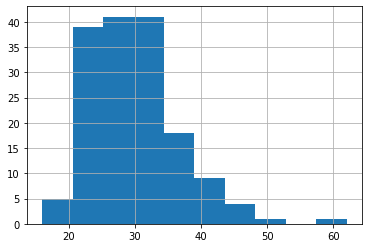

In [16]:
stress_level.history.value.hist()

In [17]:
stress_level.grade()

,name,mu,Te,alpha,beta,tau,theta,SD,var95
2,gratitide journal бумажный + ReWi,27.800000,40,20.5,520.700000,0.045255,27.784595,4.700765,36.997925
1,gratitide journal бумажный,28.930233,43,22.0,441.895349,0.046481,28.935858,4.638343,38.026845
4,дыхание Tranquility,31.863636,22,11.5,308.795455,0.046551,31.860308,4.634868,40.944482
0,ничего,30.913043,46,23.5,1733.326087,0.014356,30.913531,8.346080,47.271547
3,ReWi,33.625000,8,4.5,320.437500,0.009743,33.464766,10.131114,53.321384


In [18]:
k2, p = stats.normaltest(stress_level.history.value)
alpha = 1e-3
print("p = {:g}".format(p))
if p < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")

p = 6.63574e-10
The null hypothesis can be rejected


p = 0.339522
The null hypothesis of normality cannot be rejected


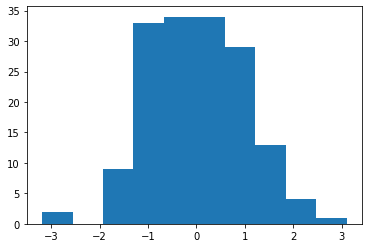

In [19]:
pt = PowerTransformer()
transformed = pt.fit_transform(stress_level.history.value.to_numpy().reshape(-1, 1))
plt.hist(transformed)


k2, p = stats.normaltest(transformed)
alpha = 1e-3
print("p = {:g}".format(p[0]))
if p < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis of normality cannot be rejected")

## Бассейн

сколько человек, включая меня/ на число дорожек

In [20]:
pool = HandsTable(["понедельник", "вторник", "среда", "четверг", "пятница"])

понедельник 1830 и пятница - 1 дорожка

пятница - нет второго сеанса

In [21]:
pool.update_hands('вторник', 2/2)
pool.update_hands('четверг', 4/2)
pool.update_hands('понедельник', 3/1)
pool.update_hands('среда', 6/2)
pool.update_hands('понедельник', 2/2)
pool.update_hands('пятница', 3/1)
pool.update_hands('четверг', 6/2)
pool.update_hands('вторник', 9/2)
pool.update_hands('четверг', 7/2)
pool.update_hands('среда', 6/2)
pool.update_hands('пятница', 3/1)
pool.update_hands('понедельник', 3/2)
pool.update_hands('среда', 3/1)
pool.update_hands('понедельник', 5/2)
pool.update_hands('четверг', 8/2) # 16 июня 


<AxesSubplot:>

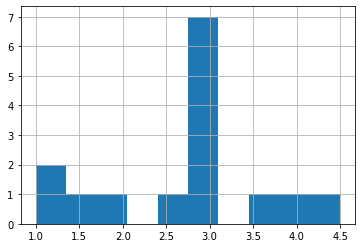

In [22]:
pool.history.value.hist()

In [23]:

pool.grade()

,name,mu,Te,alpha,beta,tau,theta,SD,var95
0,понедельник,2.000,4,2.5,1.75000,1.167789,1.921951,0.925375,3.735653
2,среда,3.000,3,2.0,0.50000,2.357436,2.592410,0.651298,3.868931
3,четверг,3.125,4,2.5,1.59375,1.154599,3.115484,0.930646,4.939516
4,пятница,3.000,2,1.5,0.50000,0.771201,3.167273,1.138718,5.399119
1,вторник,2.750,2,1.5,3.56250,0.293976,3.482028,1.844352,7.096891


## Кондиционер

на сколько градусов поставить утром и когда его выключат?

In [33]:
conditioner = HandsTable([18, 19, 20, 21, 22, 23, 24, 25, 26, 'off'], minimize=False)

In [34]:
conditioner.update_hands(23, (pd.to_timedelta('18:00:00') - pd.to_timedelta('09:00:00')).total_seconds()/3600)
conditioner.update_hands(18, (pd.to_timedelta('10:30:00') - pd.to_timedelta('08:30:00')).total_seconds()/3600)
conditioner.update_hands(26, (pd.to_timedelta('15:07:00') - pd.to_timedelta('09:00:00')).total_seconds()/3600) # жарко
conditioner.update_hands(19, (pd.to_timedelta('09:05:00') - pd.to_timedelta('08:40:00')).total_seconds()/3600) # холодно
conditioner.update_hands(24, (pd.to_timedelta('18:00:00') - pd.to_timedelta('11:30:00')).total_seconds()/3600)
conditioner.update_hands(21, (pd.to_timedelta('12:59:00') - pd.to_timedelta('11:20:00')).total_seconds()/3600)
conditioner.update_hands(25, (pd.to_timedelta('17:00:00') - pd.to_timedelta('09:38:00')).total_seconds()/3600)
conditioner.update_hands('off', (pd.to_timedelta('15:23:00') - pd.to_timedelta('09:00:00')).total_seconds()/3600) # жарко
conditioner.update_hands('off', (pd.to_timedelta('11:00:00') - pd.to_timedelta('09:00:00')).total_seconds()/3600) # hot
conditioner.update_hands(20, (pd.to_timedelta('18:00:00') - pd.to_timedelta('09:00:00')).total_seconds()/3600) 
conditioner.update_hands(20, (pd.to_timedelta('11:55:00') - pd.to_timedelta('09:00:00')).total_seconds()/3600) 
conditioner.update_hands(22, (pd.to_timedelta('16:28:00') - pd.to_timedelta('11:00:00')).total_seconds()/3600) # hot
conditioner.update_hands(23, (pd.to_timedelta('12:30:00') - pd.to_timedelta('08:38:00')).total_seconds()/3600) # hot
conditioner.update_hands(18, (pd.to_timedelta('16:20:00') - pd.to_timedelta('08:30:00')).total_seconds()/3600) # cold
conditioner.update_hands(25, (pd.to_timedelta('10:47:00') - pd.to_timedelta('08:30:00')).total_seconds()/3600) # hot
conditioner.update_hands(24, (pd.to_timedelta('16:47:00') - pd.to_timedelta('09:08:00')).total_seconds()/3600) # 3 june
conditioner.update_hands(24, (pd.to_timedelta('11:55:00') - pd.to_timedelta('09:00:00')).total_seconds()/3600) # 6 june cold
conditioner.update_hands(26, (pd.to_timedelta('14:40:00') - pd.to_timedelta('09:00:00')).total_seconds()/3600) # 7 june hot
conditioner.update_hands(18, (pd.to_timedelta('10:10:00') - pd.to_timedelta('09:00:00')).total_seconds()/3600) # 8 cold 
conditioner.update_hands(22, (pd.to_timedelta('10:10:00') - pd.to_timedelta('09:00:00')).total_seconds()/3600) # 9 cold 
conditioner.update_hands(26, (pd.to_timedelta('18:00:00') - pd.to_timedelta('09:00:00')).total_seconds()/3600) # 10 
conditioner.update_hands(26, (pd.to_timedelta('18:00:00') - pd.to_timedelta('09:00:00')).total_seconds()/3600) # 14 
conditioner.update_hands('off', (pd.to_timedelta('17:00:00') - pd.to_timedelta('09:00:00')).total_seconds()/3600) # 15 
conditioner.update_hands(24, (pd.to_timedelta('18:00:00') - pd.to_timedelta('09:40:00')).total_seconds()/3600) # 16
conditioner.update_hands(26, (pd.to_timedelta('13:30:00') - pd.to_timedelta('11:17:00')).total_seconds()/3600) # 17 жарко
conditioner.update_hands('off', (pd.to_timedelta('18:00:00') - pd.to_timedelta('09:19:00')).total_seconds()/3600) # 20
conditioner.update_hands(26, (pd.to_timedelta('13:30:00') - pd.to_timedelta('09:11:00')).total_seconds()/3600)
conditioner.update_hands(24, (pd.to_timedelta('18:00:00') - pd.to_timedelta('09:00:00')).total_seconds()/3600) # 20 ok
conditioner.update_hands(25, (pd.to_timedelta('18:00:00') - pd.to_timedelta('09:40:00')).total_seconds()/3600) # 21 ok
conditioner.update_hands(23, (pd.to_timedelta('18:00:00') - pd.to_timedelta('09:00:00')).total_seconds()/3600)
conditioner.update_hands(26, (pd.to_timedelta('16:12:00') - pd.to_timedelta('09:11:00')).total_seconds()/3600)
conditioner.update_hands(26, (pd.to_timedelta('18:00:00') - pd.to_timedelta('09:45:00')).total_seconds()/3600)
conditioner.update_hands(22, (pd.to_timedelta('11:00:00') - pd.to_timedelta('09:00:00')).total_seconds()/3600) # 27 cold 
conditioner.update_hands(24, (pd.to_timedelta('18:00:00') - pd.to_timedelta('09:00:00')).total_seconds()/3600) # 28 
conditioner.update_hands(20, (pd.to_timedelta('18:00:00') - pd.to_timedelta('09:00:00')).total_seconds()/3600) # 29
conditioner.update_hands(24, (pd.to_timedelta('11:00:00') - pd.to_timedelta('09:00:00')).total_seconds()/3600) # 30
conditioner.update_hands(20, (pd.to_timedelta('18:00:00') - pd.to_timedelta('09:00:00')).total_seconds()/3600) # 31
conditioner.update_hands(26, (pd.to_timedelta('17:00:00') - pd.to_timedelta('09:25:00')).total_seconds()/3600) # 01.07
conditioner.update_hands(20, (pd.to_timedelta('18:00:00') - pd.to_timedelta('09:00:00')).total_seconds()/3600) # 4
conditioner.update_hands('off', (pd.to_timedelta('10:20:00') - pd.to_timedelta('09:00:00')).total_seconds()/3600) # 5
conditioner.update_hands(22, (pd.to_timedelta('18:00:00') - pd.to_timedelta('10:20:00')).total_seconds()/3600) # 5
conditioner.update_hands(20, (pd.to_timedelta('18:00:00') - pd.to_timedelta('09:14:00')).total_seconds()/3600) # 6
conditioner.update_hands(20, (pd.to_timedelta('13:00:00') - pd.to_timedelta('09:06:00')).total_seconds()/3600) # 7
conditioner.update_hands(20, (pd.to_timedelta('10:40:00') - pd.to_timedelta('09:00:00')).total_seconds()/3600) # 8
conditioner.update_hands(18, (pd.to_timedelta('18:00:00') - pd.to_timedelta('09:35:00')).total_seconds()/3600) # 11
conditioner.update_hands(21, (pd.to_timedelta('18:00:00') - pd.to_timedelta('09:52:00')).total_seconds()/3600) # 12
conditioner.update_hands(23, (pd.to_timedelta('18:00:00') - pd.to_timedelta('09:11:00')).total_seconds()/3600)
conditioner.update_hands('off', (pd.to_timedelta('18:00:00') - pd.to_timedelta('09:00:00')).total_seconds()/3600) # 14
conditioner.update_hands(26, (pd.to_timedelta('18:00:00') - pd.to_timedelta('09:11:00')).total_seconds()/3600) # 15
conditioner.update_hands('off', (pd.to_timedelta('18:00:00') - pd.to_timedelta('09:00:00')).total_seconds()/3600) # 1 августа
conditioner.update_hands('off', (pd.to_timedelta('14:00:00') - pd.to_timedelta('09:00:00')).total_seconds()/3600) # 2 августа
conditioner.update_hands(22, (pd.to_timedelta('18:00:00') - pd.to_timedelta('09:00:00')).total_seconds()/3600) # 3
conditioner.update_hands(22, (pd.to_timedelta('11:00:00') - pd.to_timedelta('09:00:00')).total_seconds()/3600) # 4
conditioner.update_hands('off', (pd.to_timedelta('18:00:00') - pd.to_timedelta('09:00:00')).total_seconds()/3600) # 5
conditioner.update_hands('off', (pd.to_timedelta('18:00:00') - pd.to_timedelta('09:00:00')).total_seconds()/3600) # 8
conditioner.update_hands('off', (pd.to_timedelta('16:00:00') - pd.to_timedelta('09:00:00')).total_seconds()/3600) # 9
conditioner.update_hands(20, (pd.to_timedelta('15:40:00') - pd.to_timedelta('09:00:00')).total_seconds()/3600) # 10 ноября



<AxesSubplot:>

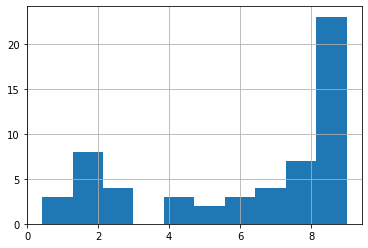

In [35]:
conditioner.history.value.hist()

p = 4.11418e-05
The null hypothesis can be rejected


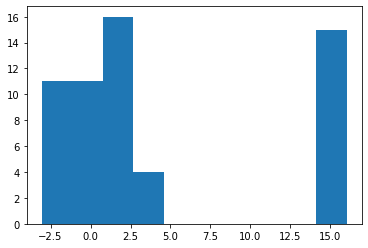

In [36]:

k2, p = stats.normaltest(conditioner.history.value)
alpha = 1e-3
plt.hist(np.log((conditioner.history.value/(9+1e-6))/(1-(conditioner.history.value/(9+1e-6)))))
print("p = {:g}".format(p))
if p < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")

p = 8.71184e-09
The null hypothesis can be rejected


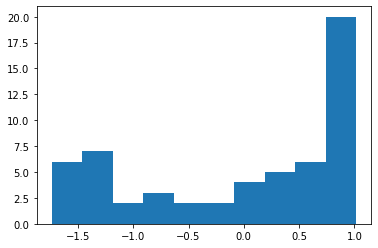

In [37]:
pt = PowerTransformer()
transformed = pt.fit_transform(conditioner.history.value.to_numpy().reshape(-1, 1))
plt.hist(transformed)


k2, p = stats.normaltest(transformed)
alpha = 1e-3
print("p = {:g}".format(p[0]))
if p < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")

In [38]:
pt.lambdas_

array([1.50577528])

In [80]:
conditioner.grade()

,name,mu,Te,alpha,beta,tau,theta,SD,var95
9,off,6.763636,11,6.0,40.855227,0.292182,6.681437,1.850005,3.055493
7,25,5.994444,3,2.0,11.062870,0.287883,5.921196,1.863767,2.268279
5,23,7.670833,4,2.5,10.158993,0.170798,7.736380,2.419686,2.993883
8,26,6.798333,10,5.5,23.217625,0.166844,6.792641,2.448190,1.994276
1,19,0.416667,1,1.0,0.500000,5.507610,0.132424,0.426107,-0.702730
2,20,6.657407,9,5.0,36.951975,0.143146,6.574791,2.643083,1.394444
6,24,6.485714,7,4.0,25.636230,0.102114,6.290107,3.129380,0.156634
4,22,4.550000,6,3.5,27.904167,0.121111,4.295652,2.873486,-1.336277
0,18,4.854167,4,2.5,22.155382,0.079381,4.617526,3.549301,-2.338976
3,21,4.891667,2,1.5,11.008403,0.013818,5.591753,8.507046,-11.081751
